# Foreign Exchange Daily Returns Series

We are generating a Daily Returns Time Series for FX investing. 

## Data Sources

Bloomberg is used to pull all of the data necessary for building this returns series. We will be using FX spot rates and interest rates (get specific pull data for this later). 

## Methodology

$$
ret_{t, i} = \frac{spot_{t - 1, i} \times fret_{t, i}}{spot_{t, i}}
$$
where
- $i$ is the foreign currency
- $t$ is the date of the implied foreign currency return
- $ret$ is the return of USD invested in the foreign currency
- $fret$ is the return of the foreign currency when invested in their overnight repo market
- $spot$ is the spot price of the currency (how much 1 USD is worth in the foreign currency)

We are replicating a process where we convert our USD into the foreign currency $i$ at end of day $t - 1$, invest it in the repo market, then switch the currency back to USD on day $t$. 


In [57]:
import pandas as pd
import numpy as np

from calc_fx import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# DATA_DIR = config("DATA_DIR")

DATA_DIR = r"../../../FS-project_files/FX-files"

# Initial Pull and analysis

FX_SPOT_RATES = r"fx_spot_rates.parquet"
FX_INTEREST_RATES = r"fx_interest_rates.parquet"

In [59]:
fx_spot = pd.read_parquet(f"{DATA_DIR}/{FX_SPOT_RATES}")
fx_interest = pd.read_parquet(f"{DATA_DIR}/{FX_INTEREST_RATES}")

In [60]:
fx_data = prepare_fx_data(fx_spot, fx_interest)
currency_list = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK', 'USD']

## FX raw data

The FX data we see is pulled from Bloomberg, then aggregated for consistent naming.
- CUR_spot is the spot price of the currency (how much 1 USD is worth in the foreign currency CUR)
- CUR_ir is the interest rate of CUR

In [61]:
fx_data.head()

,AUD_spot,CAD_spot,CHF_spot,EUR_spot,GBP_spot,JPY_spot,NZD_spot,SEK_spot,AUD_ir,CAD_ir,CHF_ir,EUR_ir,GBP_ir,JPY_ir,NZD_ir,SEK_ir,USD_ir
index,,,,,,,,,,,,,,,,,
1999-02-08,1.538698,1.4923,1.4162,0.883158,0.610016,114.55,1.797268,7.8442,NaN,NaN,NaN,3.102,NaN,NaN,NaN,NaN,NaN
1999-02-09,1.548947,1.4955,1.4158,0.883783,0.610538,114.08,1.810610,7.8820,NaN,NaN,NaN,3.102,NaN,NaN,NaN,NaN,NaN
1999-02-10,1.546312,1.4903,1.4098,0.882924,0.614817,114.36,1.812579,7.8909,NaN,NaN,NaN,3.105,NaN,NaN,NaN,NaN,NaN
1999-02-11,1.543210,1.4913,1.4254,0.891027,0.616295,114.63,1.812908,7.9437,NaN,NaN,NaN,3.097,NaN,NaN,NaN,NaN,NaN
1999-02-12,1.546073,1.4915,1.4161,0.884330,0.611658,114.25,1.819836,7.8624,NaN,NaN,NaN,3.092,NaN,NaN,NaN,NaN,NaN


In [62]:
fx_data.tail()

,AUD_spot,CAD_spot,CHF_spot,EUR_spot,GBP_spot,JPY_spot,NZD_spot,SEK_spot,AUD_ir,CAD_ir,CHF_ir,EUR_ir,GBP_ir,JPY_ir,NZD_ir,SEK_ir,USD_ir
index,,,,,,,,,,,,,,,,,
2025-06-11,1.538225,1.3672,0.8203,0.870549,0.738171,144.56,1.658375,9.5597,3.6487,2.71790,-0.09130,NaN,4.14775,0.486105,3.2050,2.0596,4.32980
2025-06-12,1.530690,1.3604,0.8102,0.863260,0.734592,143.48,1.647446,9.4476,3.6325,2.71540,-0.11025,NaN,4.14238,0.483265,3.1950,2.0523,4.32136
2025-06-13,1.541545,1.3589,0.8114,0.865876,0.736865,144.07,1.662510,9.4842,3.6918,2.72000,-0.09475,NaN,4.14150,0.486545,3.1800,2.0510,4.32205
2025-06-16,1.532802,1.3571,0.8139,0.864977,0.736485,144.75,1.649893,9.4840,3.6149,2.72185,-0.08025,NaN,4.14165,0.488675,3.1900,2.0480,4.33535
2025-06-17,1.544402,1.3679,0.8163,0.871080,0.744657,145.29,1.662787,9.5527,3.6065,2.72150,-0.09500,NaN,4.14150,0.477500,3.1875,2.0396,4.32688


In [63]:
fx_data.describe()

,AUD_spot,CAD_spot,CHF_spot,EUR_spot,GBP_spot,JPY_spot,NZD_spot,SEK_spot,AUD_ir,CAD_ir,CHF_ir,EUR_ir,GBP_ir,JPY_ir,NZD_ir,SEK_ir,USD_ir
count,6867.000000,6867.000000,6867.000000,6867.000000,6867.000000,6867.000000,6867.000000,6867.000000,6111.000000,5803.000000,4094.000000,5950.000000,6372.000000,5861.000000,5904.000000,5059.000000,6122.000000
mean,1.365537,1.259505,1.112583,0.860047,0.668894,111.648220,1.561691,8.318534,3.397166,1.884882,-0.211840,1.372351,2.270541,0.077944,3.705311,1.208167,1.744717
std,0.246089,0.170543,0.248565,0.116123,0.093709,17.147431,0.303782,1.370496,1.947307,1.477455,0.703541,1.725643,2.118162,0.168900,2.296928,1.523274,1.851967
min,0.907359,0.920400,0.720800,0.625313,0.474518,75.830000,1.133401,5.840000,0.018750,0.167500,-1.025000,-0.594300,0.023000,-0.151250,0.194100,-0.618000,0.043020
25%,1.206345,1.107650,0.929800,0.768344,0.610799,103.830000,1.372495,7.095050,1.510125,0.687970,-0.742500,-0.340000,0.437000,-0.038200,1.932500,-0.060750,0.145000
50%,1.353180,1.285400,0.994500,0.853242,0.654836,110.290000,1.480385,8.313300,3.632500,1.110000,-0.217500,0.606500,0.701050,0.039000,2.875250,0.950000,1.118000
75%,1.506932,1.361000,1.245400,0.923191,0.756315,119.525000,1.661268,9.308950,4.785000,2.859500,-0.105000,2.882625,4.528625,0.089000,5.537725,2.153000,2.611000
max,2.087683,1.613500,1.821500,1.208897,0.935541,161.690000,2.554278,11.365500,7.398500,5.165000,1.882500,5.095000,5.985000,0.699000,8.371250,5.040000,5.443200


In [64]:
fx_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6867 entries, 1999-02-08 to 2025-06-17
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AUD_spot  6867 non-null   float64
 1   CAD_spot  6867 non-null   float64
 2   CHF_spot  6867 non-null   float64
 3   EUR_spot  6867 non-null   float64
 4   GBP_spot  6867 non-null   float64
 5   JPY_spot  6867 non-null   float64
 6   NZD_spot  6867 non-null   float64
 7   SEK_spot  6867 non-null   float64
 8   AUD_ir    6111 non-null   float64
 9   CAD_ir    5803 non-null   float64
 10  CHF_ir    4094 non-null   float64
 11  EUR_ir    5950 non-null   float64
 12  GBP_ir    6372 non-null   float64
 13  JPY_ir    5861 non-null   float64
 14  NZD_ir    5904 non-null   float64
 15  SEK_ir    5059 non-null   float64
 16  USD_ir    6122 non-null   float64
dtypes: float64(17)
memory usage: 965.7+ KB


# Implied Daily Returns Time Series

Through the *methodology* described above, we then calculate the implied daily returns on foreign currency invesment.

In [70]:
impl_fx_ret = implied_daily_fx_returns(fx_data, currency_list)

c:\Users\xuv14\Spring-2025-Projects\ftsfa\src\foreign_exchange\calc_fx.py:140: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  


<Axes: xlabel='index'>

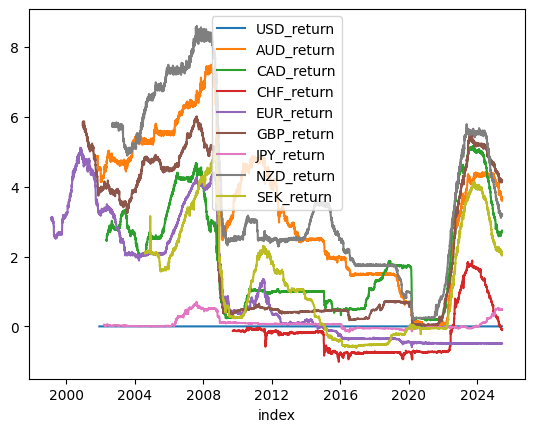

In [71]:
impl_fx_ret.plot()

In [67]:
date20 = pd.to_datetime("2022-01-01").date()
impl_fx_ret20 = impl_fx_ret.loc[date20:]
fx_data20 = fx_data.loc[date20:]

In [68]:
impl_fx_ret20.head(20)

,USD_return,AUD_return,CAD_return,CHF_return,EUR_return,GBP_return,JPY_return,NZD_return,SEK_return
index,,,,,,,,,
2022-01-03,0.000003,0.059237,0.297474,-0.714900,-0.490147,0.338300,-0.035699,0.877901,-0.047277
2022-01-04,0.000003,0.100606,0.290155,-0.708403,-0.487431,0.355681,-0.035252,0.873938,-0.051436
2022-01-05,0.000004,0.112734,0.299126,-0.713322,-0.485838,0.356289,-0.034363,0.889067,-0.051582
2022-01-06,0.000004,0.118468,0.308346,-0.714435,-0.487733,0.365173,-0.032422,0.889955,-0.058253
2022-01-07,0.000004,0.063831,0.319824,-0.709646,-0.484257,0.363496,-0.031427,0.879889,-0.045511
2022-01-10,0.000004,0.066101,0.322917,-0.717779,-0.488505,0.381309,-0.031776,0.902563,-0.051819
2022-01-11,0.000004,0.066628,0.333244,-0.708209,-0.485243,0.385354,-0.030667,0.900205,-0.051089
2022-01-12,0.000004,0.064340,0.342195,-0.703498,-0.483808,0.388619,-0.031379,0.919825,-0.051956
2022-01-13,0.000005,0.072510,0.371226,-0.708312,-0.486447,0.389358,-0.031877,0.928908,-0.053465


In [69]:
fx_data20.head(50)

,AUD_spot,CAD_spot,CHF_spot,EUR_spot,GBP_spot,JPY_spot,NZD_spot,SEK_spot,AUD_ir,CAD_ir,CHF_ir,EUR_ir,GBP_ir,JPY_ir,NZD_ir,SEK_ir,USD_ir
index,,,,,,,,,,,,,,,,,
2022-01-03,1.390821,1.2745,0.9192,0.885191,0.741840,115.32,1.473839,9.1076,0.05865,0.29500,-0.7100,NaN,0.3370,-0.035625,0.87250,-0.0470,0.12095
2022-01-04,1.381979,1.2708,0.9161,0.885975,0.739098,116.15,1.468860,9.0962,0.10125,0.29100,-0.7108,NaN,0.3570,-0.035000,0.87690,-0.0515,0.12351
2022-01-05,1.384850,1.2756,0.9169,0.883861,0.737626,116.11,1.471454,9.1106,0.11250,0.29800,-0.7127,NaN,0.3570,-0.034375,0.88750,-0.0515,0.13262
2022-01-06,1.396258,1.2729,0.9212,0.885191,0.738989,115.83,1.481701,9.1503,0.11750,0.30900,-0.7111,NaN,0.3645,-0.032500,0.88380,-0.0580,0.14179
2022-01-07,1.392564,1.2643,0.9188,0.880204,0.735943,115.56,1.475144,9.0530,0.06400,0.32200,-0.7115,NaN,0.3650,-0.031500,0.88380,-0.0460,0.14750
2022-01-10,1.394700,1.2679,0.9273,0.882924,0.736540,115.20,1.478852,9.1090,0.06600,0.32200,-0.7112,NaN,0.3810,-0.031875,0.90030,-0.0515,0.15284
2022-01-11,1.386963,1.2575,0.9234,0.879740,0.733407,115.30,1.473622,9.0363,0.06700,0.33600,-0.7112,NaN,0.3870,-0.030640,0.90340,-0.0515,0.15125
2022-01-12,1.372872,1.2509,0.9143,0.873973,0.729874,114.64,1.459854,8.9427,0.06500,0.34400,-0.7105,NaN,0.3905,-0.031560,0.92850,-0.0525,0.15685
2022-01-13,1.373061,1.2520,0.9111,0.872981,0.729607,114.20,1.457513,8.9369,0.07250,0.37090,-0.7108,NaN,0.3895,-0.032000,0.93040,-0.0535,0.16625
